In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from os import listdir
from os.path import isfile, join
from skimage import io, transform
import torch
import numpy as np

In [3]:
class YoutubeBoundinBoxDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        
        framefolder = [f for f in listdir(root_dir)]
        
        self.boundingbox_frames = csv_file
        self.boundingbox_frames['timestamp_ms'] = self.boundingbox_frames['timestamp_ms'].astype(int)  # convert to int
        self.boundingbox_frames = self.boundingbox_frames.query('youtube_id.isin(@framefolder)') # check if video is stored
        self.boundingbox_frames['object_presence'] = 1*(self.boundingbox_frames['object_presence']=='present') # one hot encoding
        
        # Only keep points that are existing in the folder 
        all_existing_frames_files = [f+'\\'+t for f in listdir(root_dir) for t in listdir(root_dir+f'\\{f}')] #list of existing frames
        mask = (self.boundingbox_frames['youtube_id'] + '\\'+self.boundingbox_frames['timestamp_ms'].astype(str)+'.jpeg').isin(all_existing_frames_files)
        self.boundingbox_frames = self.boundingbox_frames[mask]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.boundingbox_frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample_df = self.boundingbox_frames.iloc[idx]
        youtube_id, timestamp_ms, class_id, object_id, xmin, xmax, ymin, ymax, object_presence = sample_df[['youtube_id', 'timestamp_ms', 'class_id', 'object_id', 'xmin', 'xmax', 'ymin', 'ymax', 'object_presence']]
        image_file = self.root_dir + f'\\{youtube_id}\\{timestamp_ms}.jpeg' 
        image = io.imread(image_file)
        sample = {'search':search,
                  'template':template,
                  'object_presence':object_presence,
                  'xmin':xmin, 
                  'xmax':xmax, 'ymin':ymin, 'ymax':ymax}
        if self.transform : 
            sample = self.transform(sample)
        return sample


In [4]:
label_path = '../../TrainingDataset/youtube_bounding_box/'
training_label_path = label_path + 'yt_bb_detection_train/youtube_boundingboxes_detection_train.csv'
validation_label_path = label_path + 'yt_bb_detection_validation/youtube_boundingboxes_detection_validation.csv'

root_dir = 'D:\\datasets\\TargetBoxDatasets\\YoutubeBoundingBoxes\\videos\\boudingboxes_detection\\frames'

columns = ['youtube_id', 'timestamp_ms', 'class_id', 'class_name', 'object_id', 'object_presence', 
        'xmin', 'xmax', 'ymin', 'ymax']

csv_file = pd.read_csv(training_label_path, names=columns)

# Add groundtruth.txt

In [5]:
framefolder = [f for f in listdir(root_dir)]

csv_file['timestamp_ms'] = csv_file['timestamp_ms'].astype(int)  # convert to int
csv_file = csv_file.query('youtube_id.isin(@framefolder)') # check if video is stored
csv_file['object_presence'] = 1*(csv_file['object_presence']=='present') # one hot encoding

# Only keep points that are existing in the folder 
all_existing_frames_files = [f+'\\'+t for f in listdir(root_dir) for t in listdir(root_dir+f'\\{f}')] #list of existing frames
mask = (csv_file['youtube_id'] + '\\'+csv_file['timestamp_ms'].astype(str)+'.jpeg').isin(all_existing_frames_files)
csv_file = csv_file[mask]

In [6]:
csv_file

,youtube_id,timestamp_ms,class_id,class_name,object_id,object_presence,xmin,xmax,ymin,ymax
0,AAB6lO-XiKE,238000,0,person,0,1,0.482,0.540,0.371667,0.616667
1,AAB6lO-XiKE,239000,0,person,0,1,0.514,0.588,0.363333,0.606667
2,AAB6lO-XiKE,240000,0,person,0,1,0.534,0.614,0.443333,0.685000
3,AAB6lO-XiKE,241000,0,person,0,1,0.515,0.605,0.448333,0.686667
4,AAB6lO-XiKE,242000,0,person,0,1,0.550,0.600,0.400000,0.638333
...,...,...,...,...,...,...,...,...,...,...
11380,ZClABNZVqqw,28000,0,person,0,0,-1.000,-1.000,-1.000000,-1.000000
11381,ZClABNZVqqw,29000,0,person,0,0,-1.000,-1.000,-1.000000,-1.000000
11382,ZClABNZVqqw,30000,0,person,0,0,-1.000,-1.000,-1.000000,-1.000000
11383,ZClABNZVqqw,31000,0,person,0,0,-1.000,-1.000,-1.000000,-1.000000


In [7]:
all_existing_frames_files = [f+'\\'+t for f in listdir(root_dir) for t in listdir(root_dir+f'\\{f}')] #list of existing frames
all_existing_frames_files = [img_name for img_name in all_existing_frames_files if not img_name.find('.jpeg')==-1] #list of existing frames

In [8]:
import os
framsize=255

In [12]:
for file in framefolder[:]:
    subframe_folder = os.path.join(root_dir, file)  
    file1 = open(os.path.join(subframe_folder, "groundtruth.txt")  ,"w") 
    
    existing_frame_files = [img_name for img_name in os.listdir(subframe_folder) if not img_name.find('.jpeg')==-1] #list of existing frames    
    existing_frame_times = [img_name.replace('.jpeg','') for img_name in os.listdir(subframe_folder) if not img_name.find('.jpeg')==-1] #list of existing frames    
    
    for tstamp in existing_frame_times:
        xmin, xmax, ymin, ymax = framsize*csv_file.query('youtube_id == @file & timestamp_ms == @tstamp')[['xmin', 'xmax', 'ymin', 'ymax']].values[0]
        
        x,y,w,h = xmin, ymin, xmax-xmin, ymax-ymin
        line = f'{x},{y},{w},{h}\n'
        file1.write(line)
    file1.close()

In [63]:
yt_dataset = YoutubeBoundinBoxDataset(csv_file, root_dir)

<ipython-input-62-442b11c67adf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.boundingbox_frames['object_presence'] = 1*(self.boundingbox_frames['object_presence']=='present') # one hot encoding


In [81]:
dataset_loader = DataLoader(yt_dataset,
                             batch_size=32, shuffle=True,
                             num_workers=0)

In [82]:
test = next(iter(dataset_loader))

In [83]:
test

{'image': tensor([[[[ 43,  44,  36],
           [ 43,  44,  36],
           [ 43,  44,  36],
           ...,
           [ 28,  30,  19],
           [ 29,  31,  20],
           [ 29,  31,  20]],
 
          [[ 43,  44,  36],
           [ 43,  44,  36],
           [ 43,  44,  36],
           ...,
           [ 28,  30,  19],
           [ 29,  31,  20],
           [ 29,  31,  20]],
 
          [[ 43,  44,  36],
           [ 43,  44,  36],
           [ 43,  44,  36],
           ...,
           [ 29,  31,  20],
           [ 30,  32,  21],
           [ 30,  32,  21]],
 
          ...,
 
          [[ 41,  42,  34],
           [ 41,  42,  34],
           [ 41,  42,  34],
           ...,
           [ 10,  11,   6],
           [ 10,  11,   6],
           [ 10,  11,   6]],
 
          [[ 41,  42,  34],
           [ 41,  42,  34],
           [ 41,  42,  34],
           ...,
           [  9,  10,   5],
           [ 10,  11,   6],
           [ 10,  11,   6]],
 
          [[ 41,  42,  34],
           

In [70]:
import math
def get_anchor_shape(a):
    s = a**2
    r = [[3*math.sqrt(s/3.),math.sqrt(s/3.)], [2*math.sqrt(s/2.),math.sqrt(s/2.)], 
             [a,a], [math.sqrt(s/2.),2*math.sqrt(s/2.)], [math.sqrt(s/3.),3*math.sqrt(s/3.)]]
    return [list(map(round, i)) for i in r]

In [71]:
get_anchor_shape(64)

[[111, 37], [91, 45], [64, 64], [45, 91], [37, 111]]

In [84]:
def generate_anchor(total_stride, scales, ratios, score_size):
    anchor_num = len(ratios) * len(scales)
    anchor = np.zeros((anchor_num, 4),  dtype=np.float32)
    size = total_stride * total_stride
    count = 0
    for ratio in ratios:
        # ws = int(np.sqrt(size * 1.0 / ratio))
        ws = int(np.sqrt(size / ratio))
        hs = int(ws * ratio)
        for scale in scales:
            wws = ws * scale
            hhs = hs * scale
            anchor[count, 0] = 0
            anchor[count, 1] = 0
            anchor[count, 2] = wws
            anchor[count, 3] = hhs
            count += 1

    anchor = np.tile(anchor, score_size * score_size).reshape((-1, 4))
    ori = - (score_size / 2) * total_stride
    xx, yy = np.meshgrid([ori + total_stride * dx for dx in range(score_size)],
                         [ori + total_stride * dy for dy in range(score_size)])
    xx, yy = np.tile(xx.flatten(), (anchor_num, 1)).flatten(), \
             np.tile(yy.flatten(), (anchor_num, 1)).flatten()
    anchor[:, 0], anchor[:, 1] = xx.astype(np.float32), yy.astype(np.float32)
    return anchor

In [91]:
class TrackerConfig(object):
    # These are the default hyper-params for DaSiamRPN 0.3827
    windowing = 'cosine'  # to penalize large displacements [cosine/uniform]
    # Params from the network architecture, have to be consistent with the training
    exemplar_size = 127  # input z size
    instance_size = 271  # input x size (search region)
    total_stride = 8
    score_size = (instance_size-exemplar_size)/total_stride+1
    context_amount = 0.5  # context amount for the exemplar
    ratios = [0.33, 0.5, 1, 2, 3]
    scales = [8, ]
    anchor_num = len(ratios) * len(scales)
    anchor = []
    penalty_k = 0.055
    window_influence = 0.42
    lr = 0.295
    # adaptive change search region #
    adaptive = True

    def update(self, cfg):
        for k, v in cfg.items():
            setattr(self, k, v)
        self.score_size = (self.instance_size - self.exemplar_size) / self.total_stride + 1

In [92]:
cfg = {'lr': 0.30, 'window_influence': 0.40, 'penalty_k': 0.22, 'instance_size': 271, 'adaptive': False} #
p = TrackerConfig()
p.update(cfg)

In [95]:
p.score_size

19.0

In [97]:
anchor = generate_anchor(p.total_stride, p.scales, p.ratios, int(p.score_size))

In [102]:
anchor.shape

(1805, 4)

In [108]:
anchor[:20]

array([[-76., -76., 104.,  32.],
       [-68., -76., 104.,  32.],
       [-60., -76., 104.,  32.],
       [-52., -76., 104.,  32.],
       [-44., -76., 104.,  32.],
       [-36., -76., 104.,  32.],
       [-28., -76., 104.,  32.],
       [-20., -76., 104.,  32.],
       [-12., -76., 104.,  32.],
       [ -4., -76., 104.,  32.],
       [  4., -76., 104.,  32.],
       [ 12., -76., 104.,  32.],
       [ 20., -76., 104.,  32.],
       [ 28., -76., 104.,  32.],
       [ 36., -76., 104.,  32.],
       [ 44., -76., 104.,  32.],
       [ 52., -76., 104.,  32.],
       [ 60., -76., 104.,  32.],
       [ 68., -76., 104.,  32.],
       [-76., -68., 104.,  32.]], dtype=float32)

In [125]:
def plot_anchors(ancs):
    for anc in ancs:
        x,y,w,h = anc
        x=abs(x)
        y=abs(y)
        plt.plot([x, x+w, x+w, x, x],[y, y, y+h, y+h, y])

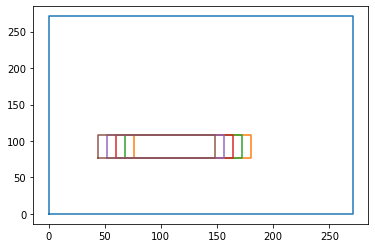

In [129]:
plot_anchors([[0,0,271,271]])
plot_anchors(anchor[:5])